In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [3]:
# Read in the training and testing data
training_df = pd.read_csv('/kaggle/input/titanic/train.csv', index_col='PassengerId')
testing_df = pd.read_csv('/kaggle/input/titanic/test.csv', index_col='PassengerId')

# Getting relevant information about dtypes and any missing values
print(training_df.info())
print(testing_df.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
Survived    891 non-null int64
Pclass      891 non-null int64
Name        891 non-null object
Sex         891 non-null object
Age         714 non-null float64
SibSp       891 non-null int64
Parch       891 non-null int64
Ticket      891 non-null object
Fare        891 non-null float64
Cabin       204 non-null object
Embarked    889 non-null object
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 418 entries, 892 to 1309
Data columns (total 10 columns):
Pclass      418 non-null int64
Name        418 non-null object
Sex         418 non-null object
Age         332 non-null float64
SibSp       418 non-null int64
Parch       418 non-null int64
Ticket      418 non-null object
Fare        417 non-null float64
Cabin       91 non-null object
Embarked    418 non-null object
dtypes: float64(2), int64(3), object(5)
memory usag

In [4]:
# Extract meaning from 'Cabin' column to get which deck the passenger was on
# Checking data type of 'Cabin' column first
print(training_df.Cabin.dtype)

# Chaninging the 'Cabin' column into a string
training_df = training_df.astype({'Cabin':'str'})
testing_df = testing_df.astype({'Cabin':'str'})

# Defining a function to get the first character of a non NaN string
def get_first(string):
    if string != 'nan':
        return string[0]
    else:
        return 'NaN'

# Getting the first letter of each cabin to make a Deck column
training_df['Deck'] = training_df['Cabin'].map(get_first)
print(training_df.Deck.value_counts())
testing_df['Deck'] = testing_df['Cabin'].map(get_first)


# Only one 'T' deck cabin, merits investigation
print(training_df[training_df['Deck']=='T'])

# A quick google search of Stephen Weart Blackwell showed him having a cabin on the "boat" deck

# T deck is not present in the test set, so the 'Deck' column needs to have its category set
from pandas.api.types import CategoricalDtype
decks = ['NaN', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T']
cat_decks = CategoricalDtype(categories=decks)
training_df.Deck = training_df.Deck.astype(cat_decks)
testing_df.Deck = testing_df.Deck.astype(cat_decks)
testing_df.Deck.dtype

object
NaN    687
C       59
B       47
D       33
E       32
A       15
F       13
G        4
T        1
Name: Deck, dtype: int64
             Survived  Pclass                          Name   Sex   Age  \
PassengerId                                                               
340                 0       1  Blackwell, Mr. Stephen Weart  male  45.0   

             SibSp  Parch  Ticket  Fare Cabin Embarked Deck  
PassengerId                                                  
340              0      0  113784  35.5     T        S    T  


CategoricalDtype(categories=['NaN', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T'], ordered=False)

In [5]:
# Combining the sibling, spouse, parents, and children into a 'Family' column
def sum_family(df):
    df['Family'] = df['SibSp'] + df['Parch']

sum_family(training_df)
sum_family(testing_df)

print(training_df.head())

             Survived  Pclass  \
PassengerId                     
1                   0       3   
2                   1       1   
3                   1       3   
4                   1       1   
5                   0       3   

                                                          Name     Sex   Age  \
PassengerId                                                                    
1                                      Braund, Mr. Owen Harris    male  22.0   
2            Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0   
3                                       Heikkinen, Miss. Laina  female  26.0   
4                 Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0   
5                                     Allen, Mr. William Henry    male  35.0   

             SibSp  Parch            Ticket     Fare Cabin Embarked Deck  \
PassengerId                                                                
1                1      0         A/5 21171   7.2500   

In [6]:
# Dropping unnecessary columns
cols_to_drop = ['Name', 'SibSp', 'Parch', 'Ticket', 'Cabin']
training_df.drop(columns=cols_to_drop, inplace=True)
testing_df.drop(columns=cols_to_drop, inplace=True)

print(training_df.columns)

Index(['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Deck',
       'Family'],
      dtype='object')


In [7]:
# Generate dummy columns for non-numeric data
training_dummies = pd.get_dummies(training_df, drop_first=True)
print(training_dummies.head())

testing_dummies = pd.get_dummies(testing_df, drop_first=True)
print(testing_dummies.head())

             Survived  Pclass   Age     Fare  Family  Sex_male  Embarked_Q  \
PassengerId                                                                  
1                   0       3  22.0   7.2500       1         1           0   
2                   1       1  38.0  71.2833       1         0           0   
3                   1       3  26.0   7.9250       0         0           0   
4                   1       1  35.0  53.1000       1         0           0   
5                   0       3  35.0   8.0500       0         1           0   

             Embarked_S  Deck_A  Deck_B  Deck_C  Deck_D  Deck_E  Deck_F  \
PassengerId                                                               
1                     1       0       0       0       0       0       0   
2                     0       0       0       1       0       0       0   
3                     1       0       0       0       0       0       0   
4                     1       0       0       1       0       0       0   
5  

Text(0.5, 0.98, 'Chance of Survival')

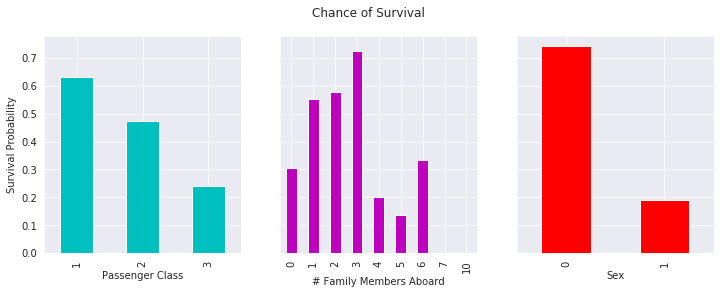

In [8]:
# Running some statistical tests on the data to examine relationships
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
%matplotlib inline

# Plotting survival rate for each of Pclass, Family, and Sex
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(12, 4))
training_dummies.groupby('Pclass').Survived.mean().plot(ax=ax1, kind='bar', color='c')
ax1.set_xlabel('Passenger Class')
ax1.set_ylabel('Survival Probability')
training_dummies.groupby('Family').Survived.mean().plot(ax=ax2, kind='bar', color='m')
ax2.set_xlabel('# Family Members Aboard')
training_dummies.groupby('Sex_male').Survived.mean().plot(ax=ax3, kind='bar', color='r')
ax3.set_xlabel('Sex')
plt.suptitle('Chance of Survival')

# These graphs show an increased chance of survival for passengers who are female, have a few family members with them aboard, and a 'higher' passenger class


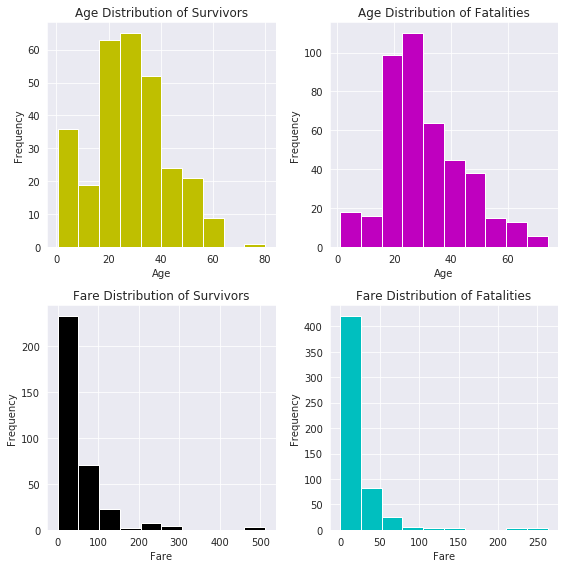

In [9]:
# Examining Age and Fare with histograms
# Separating the columns by survival to visualize trends in who survived
age_survived = training_dummies.Age[training_dummies['Survived']==1]
age_died = training_dummies.Age[training_dummies['Survived']==0]
fare_survived = training_dummies.Fare[training_dummies['Survived']==1]
fare_died = training_dummies.Fare[training_dummies['Survived']==0]

fig, axs = plt.subplots(2, 2, figsize=(8, 8))
age_survived.plot(kind='hist', ax=axs[0,0], color='y')
axs[0,0].set_xlabel('Age')
axs[0,0].set_title('Age Distribution of Survivors')

age_died.plot(kind='hist', ax=axs[0,1], color='m')
axs[0,1].set_xlabel('Age')
axs[0,1].set_title('Age Distribution of Fatalities')

fare_survived.plot(kind='hist', ax=axs[1,0], color='k')
axs[1,0].set_xlabel('Fare')
axs[1,0].set_title('Fare Distribution of Survivors')

fare_died.plot(kind='hist', ax=axs[1,1], color='c')
axs[1,1].set_xlabel('Fare')
axs[1,1].set_title('Fare Distribution of Fatalities')

plt.tight_layout()

# The distribution of ages look pretty similar, so not much information gained there
# The distribution of fare has vastly different scales and the survivors show how paying more for a ticket could point toward a higher survival rate

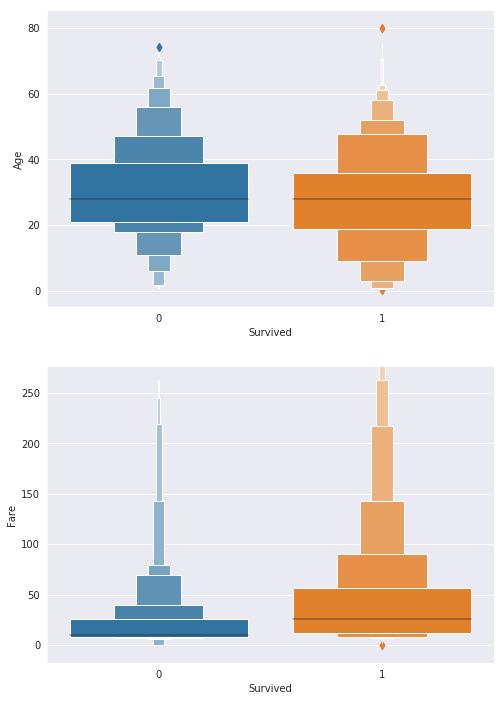

In [28]:
# Since the scale was so off on the fare histograms, I decided later a boxenplot would better show the data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8,12))
sns.boxenplot(x='Survived', y='Age', data=training_dummies, ax=ax1)
sns.boxenplot(x='Survived', y='Fare', data=training_dummies, ax=ax2)

# These plots more clearly show how age didn't have much of a difference, just a smaller trend towards younger passengers surviving a little more
# The fare plots do show a relationship between paying more for the ticket and having a higher chance of survival

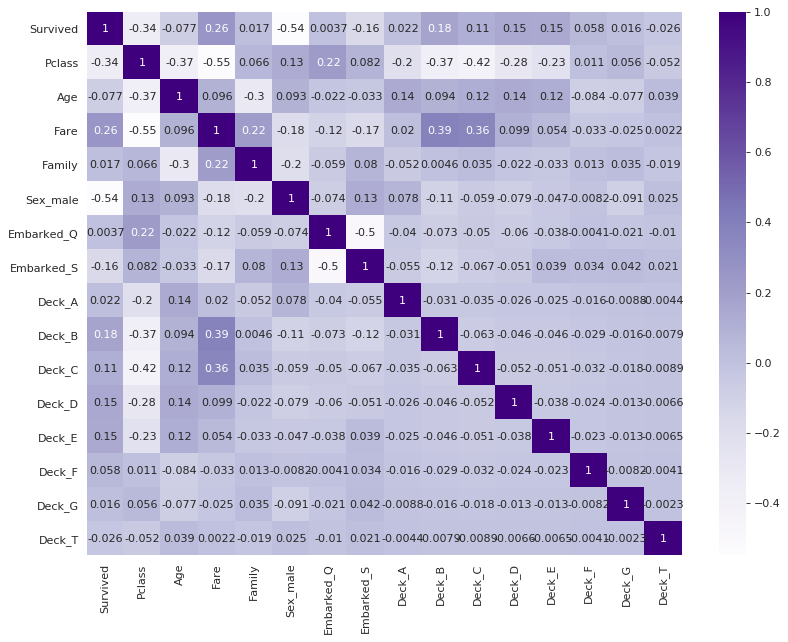

In [11]:
# Creating a heatmap to display covariance between columns
training_cov = training_dummies.corr()
plt.figure(figsize=(12,9), dpi=80)
sns.heatmap(training_cov, cmap='Purples', annot=True)

# The survived row shows a slight negative correlation between Pclass and survival, which points to the lower class numbers or 'higher class' having higher survival
# There is also a slight positive correlation beween fare and survival, telling a similar story to the previous point
# Also decks B-E may have had some positive influence on survival, but not much
# Embarking from Southhampton may have had some negative influence on survival, but not much
# There is a fairly strong negative correlation between being male and surviving, pointing towards more women surviving
# The heatmap does not show any correlation between family size and survival, but this does not describe how the chance of survival rose from 0-3 then fell if there were more than 3 members of a family

In [12]:
# Splitting the survived target column from the features
y = training_dummies.Survived
X = training_dummies.drop(columns='Survived')

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

# It is necessary to scale the Age and Fare columns so their larger values don't throw off the model
std_scaler = StandardScaler()
# Need to impute the missing values of the Age column, so the simple imputer will find the mean
imp = SimpleImputer()

# Tuned several models and have arrived at the Decision Tree providing the best results
tree = DecisionTreeClassifier(max_depth=8, criterion='gini', splitter='best', random_state=42)
knn = KNeighborsClassifier(n_neighbors=19)
logreg = LogisticRegression(max_iter=50, C=0.5, fit_intercept=True)

# Trying out an ensemble of the previous models
from sklearn.ensemble import VotingClassifier

classifiers = [('Logistic Regression', logreg), ('K Nearest Neighbors', knn), ('Decision Tree', tree)]
votclas = VotingClassifier(estimators=classifiers)


steps_ens = [('imputer', imp), ('scaler', std_scaler), ('Voting Classifier', votclas)]

pipe_ens = Pipeline(steps_ens)

pipe_ens.fit(X_train, y_train)
print("The accuracy of the ensemble is " + str(pipe_ens.score(X_test, y_test)))
# Checking cross validation score to make sure model isn't over tuned
print(cross_val_score(pipe_ens, X, y, cv=5))

The accuracy of the ensemble is 0.8100558659217877
[0.81005587 0.81460674 0.82022472 0.80337079 0.82022472]


In [13]:
# Using the tree model to predict the outcome of the test data
surv_pred = pipe_ens.predict(testing_dummies)
sub_df = pd.DataFrame(index=testing_dummies.index)
sub_df['Survived'] = surv_pred

os.chdir(r'/kaggle/working')
sub_df.to_csv(r'Ensemble_submission.csv')

from IPython.display import FileLink
FileLink(r'Ensemble_submission.csv')

/kaggle/working/Ensemble_submission.csv